# GoogLeNet

GoogLeNet（又名Inception v1）由Google团队于2014年提出，是当年ImageNet挑战赛（ILSVRC14）的冠军模型。在此之前，主流的CNN模型如AlexNet和VGG通过增加网络深度提升性能，但问题显著：  
- **参数爆炸与过拟合**：VGG参数量(VGG19, ~144M)是AlexNet(~60M)的2+倍，导致计算资源消耗巨大且容易在小数据集上过拟合。  
- **梯度消失**：网络深度增加时，反向传播的梯度难以有效传递至浅层，导致训练效率低下。  
- **信息丢失**：串联式网络结构中，深层无法恢复浅层丢失的细节特征。  

GoogLeNet的核心目标是通过**高效利用计算资源**，在控制参数量的同时提升模型性能，其解决方案是引入**Inception模块**和**辅助分类器**.

### 关键创新点：  
- **Inception模块**  
  并行使用不同尺寸的卷积核（1×1、3×3、5×5）和池化层捕捉多尺度特征，并通过1×1卷积降维控制计算量。例如，5×5卷积前使用1×1卷积将通道数从512降至16，参数量减少。 
- **辅助分类器**  
  在网络中部加入两个辅助分类器，通过加权损失缓解梯度消失问题，并起到正则化作用。  
- **全局平均池化**  
  取代全连接层，直接对特征图进行平均池化，参数量减少90%以上，同时降低过拟合风险。  
- **模块化设计**  
  Inception模块的堆叠使网络结构灵活可扩展，为后续模块化设计奠定基础。  

### 对CNN发展的影响：  
- 启发了Inception v3、ResNet等模型对多尺度特征的重视  
- 稀疏连接设计和全局平均池化成为现代CNN的标配  
- 推动了移动端轻量化模型（如MobileNet）的发展

![alt text](resources/GooLeNet_arch.png "Title")

---

## 与VGGNet的优势对比  

| 维度         | GoogLeNet                                  | VGGNet                     |
|--------------|--------------------------------------------|----------------------------|
| **参数量**   | 6M         | 144M    |
| **计算效率** | 1×1卷积和Inception模块降低计算复杂度       | 3×3卷积堆叠导致计算量陡增  |
| **结构设计** | 并行多尺度特征提取，信息保留更全面         | 单一尺度卷积，深层易丢细节 |
| **训练稳定性** | 辅助分类器缓解梯度消失，加速收敛           | 依赖ReLU和梯度裁剪         |
| **扩展性**   | 模块化设计便于调整深度与宽度               | 固定3×3卷积，扩展性受限    |

---

## 总结  
GoogLeNet通过**多尺度特征融合**与**高效参数设计**，在深度学习史上树立了里程碑。其核心理念不仅解决了当时网络的瓶颈，更为后续模型的创新提供了范式。与VGG相比，GoogLeNet在参数效率、训练稳定性和结构灵活性上更具优势，成为资源敏感场景（如移动端部署）的重要架构。

具体的参数如下:

![alt text](resources/googlenet_table.png "Title")

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory
from hdd.data_util.transforms import RandomResize

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)



TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
train_dataset_transforms = transforms.Compose(
    [
        RandomResize([256, 296, 384]),  # 随机在三个size中选择一个进行resize
        transforms.RandomRotation(10),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)

BATCH_SIZE = 128
train_dataloader = torch.utils.data.DataLoader(
    ImagenetteInMemory(
        root=DATA_ROOT,
        split="train",
        size="full",
        download=True,
        transform=train_dataset_transforms,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)
val_dataloader = torch.utils.data.DataLoader(
    ImagenetteInMemory(
        root=DATA_ROOT,
        split="val",
        size="full",
        download=True,
        transform=val_dataset_transforms,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

Use device:  cuda


GoogleNet中的基础模块有很多版面,我们选择性地查看几个版本。

### Inception V1

从下图可以清晰看到V1模型的多尺度特征融合和采用1x1卷积降低运算量的结构

![alt text](resources/inceptionV1.png "Title")

代码如下:

```python
class InceptionV1(nn.Module):
    def __init__(self, in_channel, ch_1x1, ch_3x3_reduce, ch_3x3, ch_5x5_reduce, ch_5x5, ch_pool_proj,
    ) -> None:
        super().__init__()
        self.branch1 = InceptionConv2d(in_channel, ch_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            InceptionConv2d(in_channel, ch_3x3_reduce, kernel_size=1),
            InceptionConv2d(ch_3x3_reduce, ch_3x3, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            InceptionConv2d(in_channel, ch_5x5_reduce, kernel_size=1),
            InceptionConv2d(ch_5x5_reduce, ch_5x5, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            InceptionConv2d(in_channel, ch_pool_proj, kernel_size=1),
        )

    def forward(self, X) -> torch.Tensor:
        branch1 = self.branch1(X)
        branch2 = self.branch2(X)
        branch3 = self.branch3(X)
        branch4 = self.branch4(X)
        return torch.cat([branch1, branch2, branch3, branch4], dim=1)
```

**不使用Auxiliary Classifier**

In [2]:
from hdd.models.cnn.googlenet import GoogLeNet, InceptionV1
from hdd.train.early_stopping import EarlyStoppingInMem
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter

net = GoogLeNet(InceptionV1, num_classes=10, dropout=0.5, use_aux=False).to(DEVICE)
print("Trainable parameter in GoogLeNet V1: ", count_trainable_parameter(net))
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=20, gamma=0.1, last_epoch=-1
)
early_stopper = EarlyStoppingInMem(patience=15, verbose=False)
max_epochs = 100
training_stats_v1 = naive_train_classification_model(
    net,
    criteria,
    max_epochs,
    train_dataloader,
    val_dataloader,
    DEVICE,
    optimizer,
    scheduler,
    early_stopper,
    verbose=True,
)

Trainable parameter in GoogLeNet V1:  5991082
Epoch: 1/100 Train Loss: 1.7983 Accuracy: 0.3727 Time: 8.04973  | Val Loss: 1.9290 Accuracy: 0.4237
Epoch: 2/100 Train Loss: 1.3238 Accuracy: 0.5636 Time: 7.47678  | Val Loss: 1.5129 Accuracy: 0.5414
Epoch: 3/100 Train Loss: 1.1385 Accuracy: 0.6302 Time: 7.48562  | Val Loss: 1.4758 Accuracy: 0.5327
Epoch: 4/100 Train Loss: 0.9958 Accuracy: 0.6835 Time: 7.47752  | Val Loss: 1.5098 Accuracy: 0.5822
Epoch: 5/100 Train Loss: 0.9028 Accuracy: 0.7116 Time: 7.56000  | Val Loss: 1.1462 Accuracy: 0.6443
Epoch: 6/100 Train Loss: 0.8355 Accuracy: 0.7320 Time: 7.69116  | Val Loss: 0.8913 Accuracy: 0.7243
Epoch: 7/100 Train Loss: 0.7624 Accuracy: 0.7567 Time: 7.53098  | Val Loss: 0.8071 Accuracy: 0.7442
Epoch: 8/100 Train Loss: 0.7465 Accuracy: 0.7609 Time: 7.55076  | Val Loss: 0.8965 Accuracy: 0.7389
Epoch: 9/100 Train Loss: 0.7034 Accuracy: 0.7738 Time: 7.44836  | Val Loss: 0.6561 Accuracy: 0.7903
Epoch: 10/100 Train Loss: 0.6425 Accuracy: 0.7958 Time

In [3]:
eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"Accuracy V1: {sum(ss) / len(ss)}")

Accuracy V1: 0.8935031847133758


**使用Auxiliary Classifier**

In [4]:
from typing import Tuple


def train_classifier_with_aux(
    net: nn.Module,
    criteria: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    device: torch.device,
) -> Tuple[float, float]:
    train_loss = 0.0
    correct_items = 0
    total_items = 0
    net.train()
    for Xs, ys in train_loader:
        Xs, ys = Xs.to(device), ys.to(device)
        optimizer.zero_grad()
        logits, aux_logits1, aux_logits2 = net(Xs)
        # nn.CrossEntropyLoss是stateless的,可以被重复调用
        loss1 = criteria(logits, ys)
        loss2 = criteria(aux_logits1, ys)
        loss3 = criteria(aux_logits2, ys)
        loss = loss1 + 0.3 * loss2 + 0.3 * loss3
        loss.backward()
        optimizer.step()
        # 为了和Eval loss比较,我们只记录第一个loss
        train_loss += loss1.item()
        correct_items += torch.sum(torch.argmax(logits, dim=1) == ys).item()
        total_items += Xs.shape[0]

    avg_train_loss = train_loss / len(train_loader)
    accuracy = correct_items / total_items
    return avg_train_loss, accuracy


net = GoogLeNet(InceptionV1, num_classes=10, dropout=0.5, use_aux=True).to(DEVICE)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=20, gamma=0.1, last_epoch=-1
)
early_stopper = EarlyStoppingInMem(patience=15, verbose=False)
max_epochs = 100
training_stats_v1_with_aux = naive_train_classification_model(
    net,
    criteria,
    max_epochs,
    train_dataloader,
    val_dataloader,
    DEVICE,
    optimizer,
    scheduler,
    early_stopper,
    verbose=True,
    train_classifier=train_classifier_with_aux,
)

Epoch: 1/100 Train Loss: 1.8044 Accuracy: 0.3699 Time: 7.61825  | Val Loss: 2.4739 Accuracy: 0.3320
Epoch: 2/100 Train Loss: 1.3031 Accuracy: 0.5741 Time: 7.53379  | Val Loss: 1.7776 Accuracy: 0.5203
Epoch: 3/100 Train Loss: 1.1201 Accuracy: 0.6392 Time: 7.50013  | Val Loss: 1.1703 Accuracy: 0.6318
Epoch: 4/100 Train Loss: 0.9779 Accuracy: 0.6843 Time: 7.20864  | Val Loss: 0.8788 Accuracy: 0.7223
Epoch: 5/100 Train Loss: 0.9226 Accuracy: 0.7042 Time: 7.19515  | Val Loss: 0.8242 Accuracy: 0.7442
Epoch: 6/100 Train Loss: 0.8226 Accuracy: 0.7413 Time: 7.17597  | Val Loss: 0.9733 Accuracy: 0.6968
Epoch: 7/100 Train Loss: 0.7637 Accuracy: 0.7554 Time: 7.10189  | Val Loss: 0.9390 Accuracy: 0.7218
Epoch: 8/100 Train Loss: 0.7025 Accuracy: 0.7763 Time: 7.26789  | Val Loss: 0.7963 Accuracy: 0.7592
Epoch: 9/100 Train Loss: 0.6627 Accuracy: 0.7867 Time: 7.11924  | Val Loss: 0.9553 Accuracy: 0.6966
Epoch: 10/100 Train Loss: 0.6592 Accuracy: 0.7875 Time: 7.32551  | Val Loss: 0.9897 Accuracy: 0.7149

In [5]:
eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"Accuracy V1 with Aux Classifier: {sum(ss) / len(ss)}")

Accuracy V1 with Aux Classifier: 0.9054777070063694


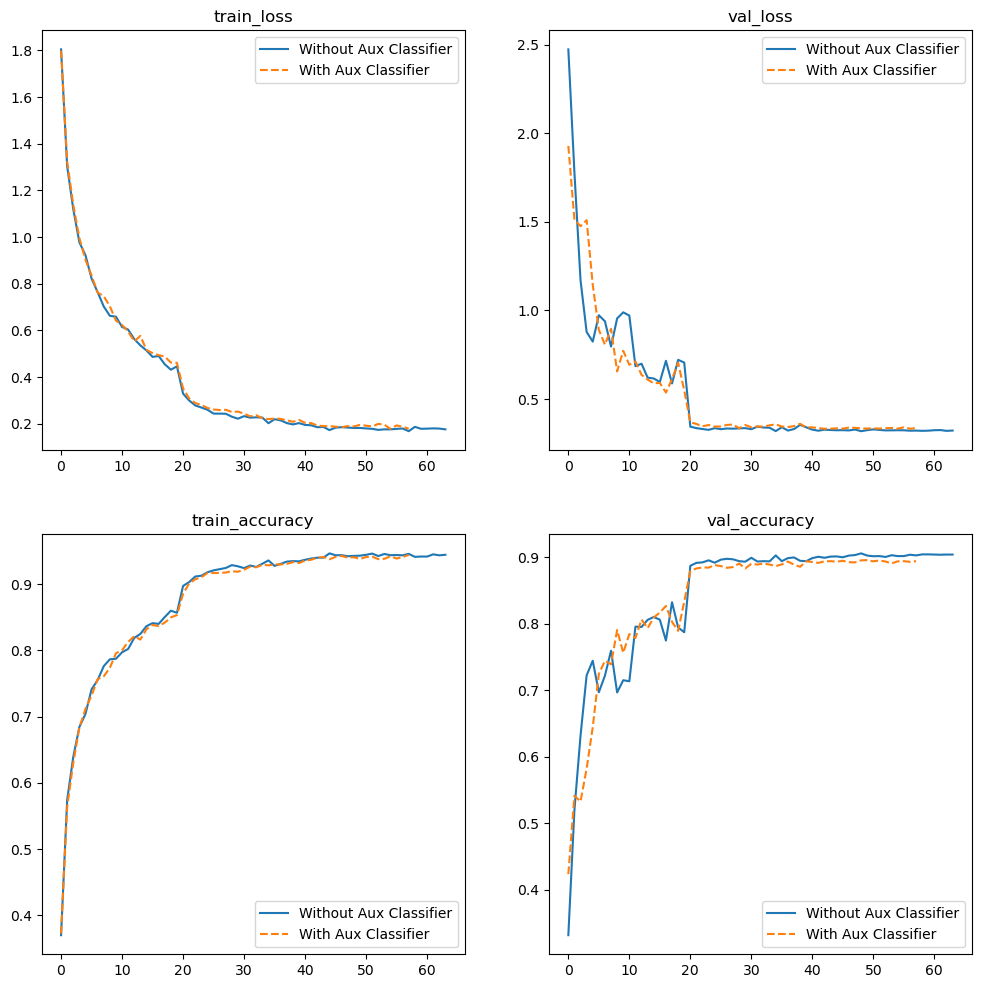

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = training_stats_v1.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(training_stats_v1_with_aux[field], label="Without Aux Classifier", linestyle="-")
    plt.plot(training_stats_v1[field], label="With Aux Classifier", linestyle="--")
    plt.legend()
    plt.title(field)

### Inception V2

V2将V1中的5✖5卷积替换为两个3x3卷积,在保持相同感受野的情况下,这样可以降低模型参数和计算量,此外额外的非线性层可以提出更复杂的特征.

![alt text](resources/inceptionV2.png "Title")


In [7]:
from hdd.models.cnn.googlenet import InceptionV2

net = GoogLeNet(InceptionV2, num_classes=10, dropout=0.5, use_aux=False).to(DEVICE)
print("Trainable parameter in GoogLeNet V2: ", count_trainable_parameter(net))
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=20, gamma=0.1, last_epoch=-1
)
early_stopper = EarlyStoppingInMem(patience=15, verbose=False)
max_epochs = 100
training_stats_v2 = naive_train_classification_model(
    net,
    criteria,
    max_epochs,
    train_dataloader,
    val_dataloader,
    DEVICE,
    optimizer,
    scheduler,
    early_stopper,
    verbose=True,
)

Trainable parameter in GoogLeNet V2:  6277514
Epoch: 1/100 Train Loss: 1.8861 Accuracy: 0.3405 Time: 7.38445  | Val Loss: 1.5027 Accuracy: 0.5251
Epoch: 2/100 Train Loss: 1.3688 Accuracy: 0.5477 Time: 7.26705  | Val Loss: 1.2750 Accuracy: 0.5918
Epoch: 3/100 Train Loss: 1.1808 Accuracy: 0.6152 Time: 7.26484  | Val Loss: 1.4623 Accuracy: 0.5297
Epoch: 4/100 Train Loss: 1.0373 Accuracy: 0.6650 Time: 7.31189  | Val Loss: 1.1084 Accuracy: 0.6431
Epoch: 5/100 Train Loss: 0.9482 Accuracy: 0.6929 Time: 7.26926  | Val Loss: 1.0551 Accuracy: 0.6678
Epoch: 6/100 Train Loss: 0.8815 Accuracy: 0.7156 Time: 7.36108  | Val Loss: 0.8842 Accuracy: 0.7228
Epoch: 7/100 Train Loss: 0.8288 Accuracy: 0.7363 Time: 7.20505  | Val Loss: 0.7105 Accuracy: 0.7697
Epoch: 8/100 Train Loss: 0.7688 Accuracy: 0.7510 Time: 7.22879  | Val Loss: 1.0661 Accuracy: 0.6739
Epoch: 9/100 Train Loss: 0.7360 Accuracy: 0.7662 Time: 7.37026  | Val Loss: 0.8132 Accuracy: 0.7424
Epoch: 10/100 Train Loss: 0.6903 Accuracy: 0.7776 Time

In [8]:
eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"Accuracy V2: {sum(ss) / len(ss)}")

Accuracy V2: 0.8876433121019108


### Inception V3

V3将V2中的nxn卷积分解为为两个(nx1,1xn)卷积,这个思路和图像处理中加速Gaussian kernel计算类似,Gaussian Kernel可分离为两个一维卷积.

![alt text](resources/inceptionV3.png "Title")


In [9]:
from hdd.models.cnn.googlenet import InceptionV3

net = GoogLeNet(InceptionV3, num_classes=10, dropout=0.5, use_aux=False).to(DEVICE)
print("Trainable parameter in GoogLeNet V3: ", count_trainable_parameter(net))
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=20, gamma=0.1, last_epoch=-1
)
early_stopper = EarlyStoppingInMem(patience=15, verbose=False)
max_epochs = 100
training_stats_v3 = naive_train_classification_model(
    net,
    criteria,
    max_epochs,
    train_dataloader,
    val_dataloader,
    DEVICE,
    optimizer,
    scheduler,
    early_stopper,
    verbose=True,
)

Trainable parameter in GoogLeNet V3:  4067754
Epoch: 1/100 Train Loss: 2.0615 Accuracy: 0.2572 Time: 7.55883  | Val Loss: 1.8972 Accuracy: 0.3363
Epoch: 2/100 Train Loss: 1.7014 Accuracy: 0.4131 Time: 7.41424  | Val Loss: 1.4619 Accuracy: 0.5022
Epoch: 3/100 Train Loss: 1.4426 Accuracy: 0.5176 Time: 7.39287  | Val Loss: 1.4019 Accuracy: 0.5498
Epoch: 4/100 Train Loss: 1.2868 Accuracy: 0.5745 Time: 7.42444  | Val Loss: 1.2250 Accuracy: 0.5992
Epoch: 5/100 Train Loss: 1.1558 Accuracy: 0.6269 Time: 7.50499  | Val Loss: 1.3352 Accuracy: 0.5896
Epoch: 6/100 Train Loss: 1.0722 Accuracy: 0.6479 Time: 7.54082  | Val Loss: 1.4504 Accuracy: 0.5766
Epoch: 7/100 Train Loss: 0.9986 Accuracy: 0.6786 Time: 7.37050  | Val Loss: 1.0726 Accuracy: 0.6690
Epoch: 8/100 Train Loss: 0.9250 Accuracy: 0.7038 Time: 7.50643  | Val Loss: 1.4303 Accuracy: 0.5783
Epoch: 9/100 Train Loss: 0.8779 Accuracy: 0.7180 Time: 7.40980  | Val Loss: 1.0169 Accuracy: 0.6777
Epoch: 10/100 Train Loss: 0.8181 Accuracy: 0.7367 Time

In [10]:
eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"Accuracy V3: {sum(ss) / len(ss)}")

Accuracy V3: 0.8797452229299363


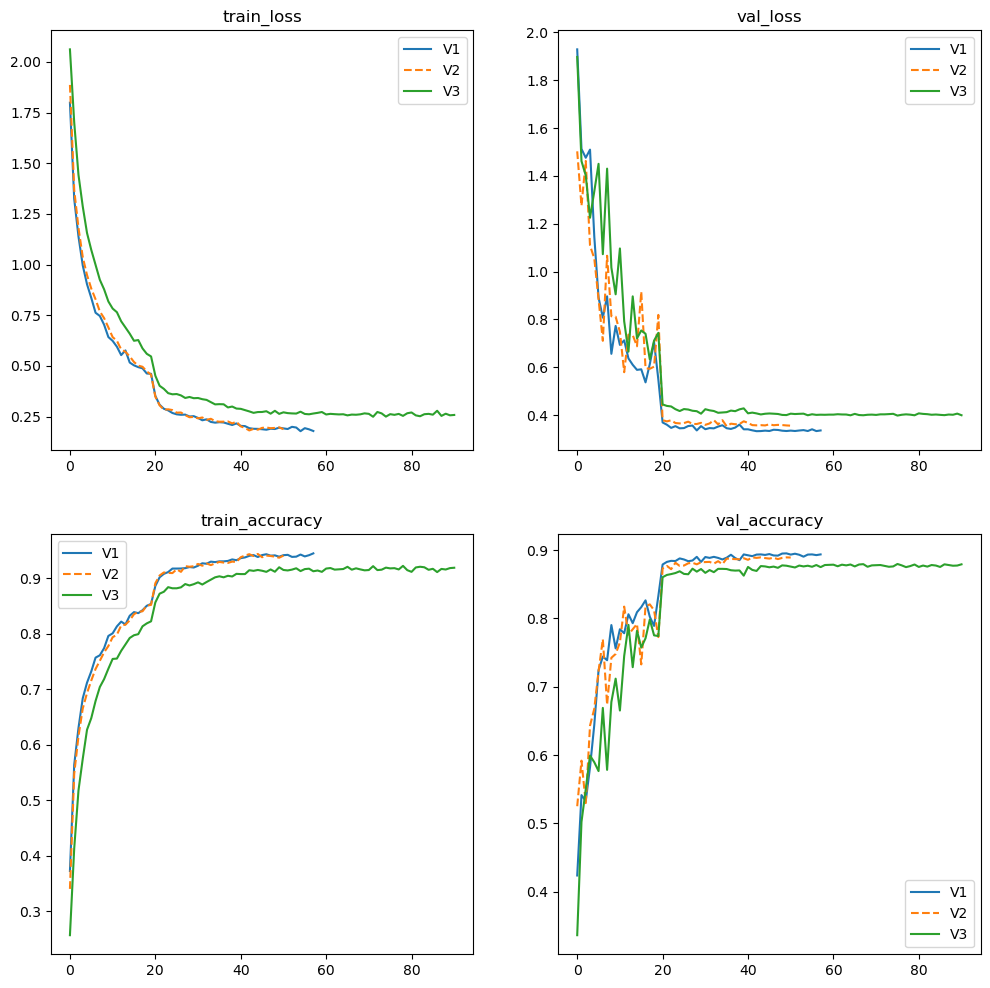

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = training_stats_v1.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(training_stats_v1[field], label="V1", linestyle="-")
    plt.plot(training_stats_v2[field], label="V2", linestyle="--")
    plt.plot(training_stats_v3[field], label="V3")
    plt.legend()
    plt.title(field)